In [14]:
#!pip install matplotlib
#!pip install pandas
#!pip install openpyxl
#!pip install ndlib
#!pip install wordcloud
#!pip install empath
#!pip install keras
#!pip install theano
#!pip install gensim
#!pip install xgboost
#!pip install NLTK
#!pip install Sklearn
#!pip install numpy
#!pip install tweepy
#!pip install tensorflow
#!pip install xlrd

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import tweepy
import csv
import json
import os

In [2]:
data = pd.read_csv("AskFm_datasets.csv", ",", index_col=None, header=None)

C:\Users\KatriSaku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


# 1. Wordcloud representations

In [3]:
from wordcloud import WordCloud

hs_text = ""
cs_text = ""

for i in range(len(data)):
    if data[1][i] == "0":
        cs_text += " " + data[0][i]
    elif data[1][i] == "1":
        hs_text += " " + data[0][i]

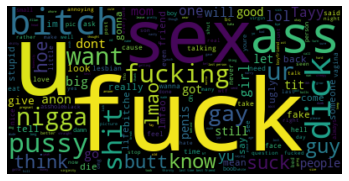

In [4]:
#Abusive content wordcloud representation
wordcloud = WordCloud().generate(hs_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

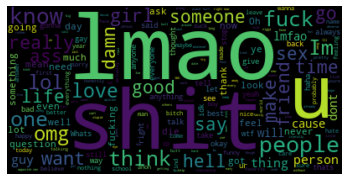

In [5]:
#Non-abusive content wordcloud representation
wordcloud = WordCloud().generate(cs_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# 2. Empath categorization

In [6]:
from empath import Empath

lexicon = Empath()

abusive_categories = []
non_abusive_categories = []

# analyze abusive content data
for i in range(1, len(data)):
    if data[1][i] == "1":
        temp = lexicon.analyze(data[0][i], normalize=True)
        for j in temp.items():
            if j[1] != 0.0:
                if j[0] not in abusive_categories:
                    abusive_categories.append(j[0])

# analyze non-abusive content data
for i in range(1, len(data)):
    if data[1][i] == "0":
        temp = lexicon.analyze(data[0][i], normalize=True)
        for j in temp.items():
            if j[1] != 0.0:
                if j[0] not in non_abusive_categories:
                    non_abusive_categories.append(j[0])
            
# combine categories into one list
while abusive_categories:
    x = abusive_categories.pop()
    if x not in non_abusive_categories:
        non_abusive_categories.append(x)
    else:
        continue

In [7]:
header = ["MESSAGE"] + ["isAbusive"] + non_abusive_categories

#empath categorization results into csv file database
def recordEmpath(filename):
    with open(filename, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f, delimiter = ";")
        writer.writerow(header)
    
        for i in range(1, len(data)):
            temp = lexicon.analyze(data[0][i], normalize=True)
            temp_data = [None] * len(header)
            temp_data[0] = data[0][i]
            temp_data[1] = data[1][i]
            for j in temp.items():
                if j[1] != 0.0:
                    for z in range(len(header)):
                        if j[0] == header[z]:
                            temp_data[z] = j[1]
            writer.writerow(temp_data)
    f.close()

In [8]:
recordEmpath("empath_dataset.csv")

# 3. Harvard General Inquirer

In [15]:
inquirerData = pd.read_excel("inquirerbasic.xls", index_col=None, header=None)

def loopInquirer():
    for j in range(1, len(inquirerData)): #WORDS FROM INQUIRER
            wordToSearch = str(inquirerData[0][j])
            if wordToSearch.endswith(suffixes):
                wordToSearch = wordToSearch[:-2]
            for word in msg_upper:
                if wordToSearch == word: #word found from inquirerData
                    for k in range(2, len(inquirerData.columns)-2): #Go through categories
                        if inquirerData[k][j] != 0:
                            temp_data[k] = inquirerData[k][j]
    return temp_data

THIS CAN TAKE UP TO 20 MINUTES!!

In [16]:
suffixes = ('#1','#2','#3','#4','#5','#6','#7')
header = ["MESSAGE"] + ["isAbusive"]

#Fill NaN values with 0
inquirerData = inquirerData.fillna(0)

for i in range(2, len(inquirerData.columns)-2):
    header = header + [str(inquirerData[i][0])]

#Harvard General Inquirer results into csv file database
with open('inquirer_dataset.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f, delimiter = ";")
    writer.writerow(header)
    
    for i in range(1, len(data)): #MESSAGES
        msg = data[0][i].replace("?","").replace("!","").replace(",","").replace(".","").replace('"',"").split(' ')
        msg_upper = [x.upper() for x in msg]
        temp_data = [None] * len(header)
        temp_data[0] = data[0][i]
        temp_data[1] = data[1][i]
        temp_data = loopInquirer()
        writer.writerow(temp_data)
    
    f.close()

# 4. Simple heuristic to identify the presence of hate content using both empath categorization and general inquirer

In [17]:
def recordResults(name, abusiveMsgInquirer, abusiveMsgEmpath):
    with open(name, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f, delimiter = ";")
        header = ["MESSAGE"] + ["isAbusiveOriginally"] + ["isAbusiveInquirer"] + ["isAbusiveEmpath"] + ["isAbusiveOR"]
        writer.writerow(header)
    
        for i in range(1, len(inquirer_data)):
            temp_data = [None] * len(header)
            temp_data[0] = inquirer_data[0][i]
            temp_data[1] = inquirer_data[1][i]
            temp_data[2] = abusiveMsgInquirer[i-1]
            temp_data[3] = abusiveMsgEmpath[i-1]

            #If inquirer OR empath categorization marked the msg as hate speech,
            #mark it as hate speech
            if (int(temp_data[2])== 1 or int(temp_data[3]) == 1):
                temp_data[4] = 1
            else:
                temp_data[4] = 0
            writer.writerow(temp_data)
    
        f.close()

In [18]:
inquirer_data = pd.read_csv("inquirer_dataset.csv", ";", index_col=None, header=None, low_memory=False)
empath_data = pd.read_csv("empath_dataset.csv", ";", index_col=None, header=None, low_memory=False)

abusiveMessagesInquirer = []
abusiveMessagesEmpath = []

# Loop all inquirer abusive messages
for i in range(1, len(inquirer_data)): # Messages
    
    #Categories that can be related to hate speech
    if inquirer_data[2][i] != "Positiv" and (inquirer_data[3][i] == "Negativ" or inquirer_data[15][i] == "Pain" or inquirer_data[33][i] == "Relig" or inquirer_data[39][i] == "Race"  or 
     (inquirer_data[42][i]  == "Female" and inquirer_data[3][i] == "Negativ") or 
     (inquirer_data[60][i] == "BodyPt" and inquirer_data[3][i] == "Negativ")):
        #Negate
        if inquirer_data[114][i] == "Negate":
            abusiveMessagesInquirer.append(0)
            continue
        else:
            abusiveMessagesInquirer.append(1)
            continue
    else:
        abusiveMessagesInquirer.append(0)
        
# Loop all empath abusive messages
for i in range(1, len(empath_data)):
    
    #Mark as hate speech if the message has no positive_emotion(10) and
    #has words from categories that could include hate speech
    
    #Categories that can be related to hate speech: 
    #violence (6), swearing_terms (11), negative_emotion (30)
    #shape_and_size (32), body(33), hate (121)
    if not float(empath_data[10][i]) > 0.0 and (float(empath_data[6][i]) > 0.0 or float(empath_data[11][i]) > 0.0 or float(empath_data[30][i]) > 0.0 or float(empath_data[32][i]) > 0.0 or float(empath_data[33][i]) > 0.0 or float(empath_data[121][i]) > 0.0):
        abusiveMessagesEmpath.append(1)
    else:
        abusiveMessagesEmpath.append(0)
        continue
        
recordResults("simpleheuristic.csv", abusiveMessagesInquirer, abusiveMessagesEmpath)

# 5. Analyzing


In [19]:
def analyzeData(filename):
    compareData = pd.read_csv(filename, ";", index_col=None, header=None, low_memory=False)
    match = 0
    matchOnes = 0
    matchZeros = 0
    ones = 0
    zeros = 0
    falsePos = 0
    falseNeg = 0

    for i in range(1, len(compareData)):
        if int(compareData[1][i]) == 1 and int(compareData[4][i]) == 1:
            match = match + 1
            matchOnes = matchOnes + 1
            ones = ones + 1
        elif int(compareData[1][i]) == 0 and int(compareData[4][i]) == 0:
            match = match + 1
            matchZeros = matchZeros + 1
            zeros = zeros + 1
        elif int(compareData[1][i]) == 0 and int(compareData[4][i]) == 1:
            falsePos = falsePos + 1
            zeros = zeros + 1
        elif int(compareData[1][i]) == 1 and int(compareData[4][i]) == 0:
            falseNeg = falseNeg + 1
            ones = ones + 1

    print(match, "out of", len(compareData)-1, "posts have the same outcome")
    print("Complete Accuracy: ", round(match/(len(compareData)-1), 3)*100, "%")
    print(falsePos, "false positives out of", zeros)
    print(falseNeg, "false negatives out of", ones)
    print(matchOnes, "real positives out of", ones)
    print(matchZeros, "real negatives out of", zeros)
    print("\nPercent of hate speech recognized: ", round((matchOnes/ones)*100,2), "%")
    print("Percent of real positives from all positives: ", round((matchOnes/(falsePos+matchOnes))*100,2), "%")
    
    
    #return Complete Accuracy
    return(str(round(match/(len(compareData)-1), 3)*100) + "%")


In [20]:
analyzeData("simpleheuristic.csv")

C:\Users\KATRIS~1\AppData\Local\Temp/ipykernel_12892/430775138.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  analyzeData("simpleheuristic.csv")


6282 out of 9998 posts have the same outcome
Complete Accuracy:  62.8 %
3200 false positives out of 8787
516 false negatives out of 1211
695 real positives out of 1211
5587 real negatives out of 8787

Percent of hate speech recognized:  57.39 %
Percent of real positives from all positives:  17.84 %


'62.8%'

# 6 & 8. Test implementations (TFIDF, CNN, LSTM)

In [23]:
"""
#Set up the SemEval datasets

CONSUMER_KEY = 'tSB2RDbxb4U1IuNQa1qLzaErM'
CONSUMER_SECRET= 'x9KEdzMELJylzqtswOLRvEn94JkxJFmOIzLwr8C9GvichYrNrD'
OAUTH_TOKEN = '757309138443628544-mz7JUvTR4x1p4iCMwj33Y9Xqgt1onwD'
OAUTH_TOKEN_SECRET = 'xT93QanDPRZUOU3dewV2RqnQ65NfBNmBhGR0P0bosMJSC'
# twitter authentication for tweepy
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tweepy.API(auth)

<-Uncomment if building the datasets
#Fetch tweets for semeval datasets
semevals = ['SemDev.json', 'SemTest2013.json', 'SemTest2014.json', 'SemTest2015.json', 'SemTrain.json']
for i in semevals:
    semeval = helper.load_json_from_file(i)
    for j in range(1, len(semeval)):
        try:
            ids = semeval[j]['tweet_id']
            text = api.get_status(ids).text
            semeval[j]['text'] = text
        except tweepy.errors.NotFound as e:
            print(e)
        except tweepy.errors.Forbidden as e:
            print(e)
        except tweepy.errors.TooManyRequests as e:
            print(e)
            time.sleep(900)
    helper.dump_json_to_file(i, semeval)
"""

"\n#Set up the SemEval datasets\nworking_dir = os.getcwd()\nos.chdir('~/datasets')\nfrom src import helper\n\nCONSUMER_KEY = 'tSB2RDbxb4U1IuNQa1qLzaErM'\nCONSUMER_SECRET= 'x9KEdzMELJylzqtswOLRvEn94JkxJFmOIzLwr8C9GvichYrNrD'\nOAUTH_TOKEN = '757309138443628544-mz7JUvTR4x1p4iCMwj33Y9Xqgt1onwD'\nOAUTH_TOKEN_SECRET = 'xT93QanDPRZUOU3dewV2RqnQ65NfBNmBhGR0P0bosMJSC'\n# twitter authentication for tweepy\nauth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)\nauth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)\napi = tweepy.API(auth)\n\n<-Uncomment if building the datasets\n#Fetch tweets for semeval datasets\nsemevals = ['SemDev.json', 'SemTest2013.json', 'SemTest2014.json', 'SemTest2015.json', 'SemTrain.json']\nfor i in semevals:\n    semeval = helper.load_json_from_file(i)\n    for j in range(1, len(semeval)):\n        try:\n            ids = semeval[j]['tweet_id']\n            text = api.get_status(ids).text\n            semeval[j]['text'] = text\n        except tweepy.errors.NotFound

IT WILL TAKE A LONG TIME (SEVERAL HOURS) TO FETCH ALL THE TWEETS!!

In [24]:
"""
#Remove entries that have 'text'=None
entries = ['SemDev.json', 'SemTest2013.json', 'SemTest2014.json', 'SemTest2015.json', 'SemTrain.json']

for entry in entries:
    datafile = helper.load_json_from_file(entry)
    # using list comprehension 
    # to delete dictionary in list
    for i in range(len(datafile)-1, -1, -1):
        if datafile[i]['text'] == None:
            del datafile[i]
    helper.dump_json_to_file(entry, datafile)
"""

"\n#Remove entries that have 'text'=None\nentries = ['SemDev.json', 'SemTest2013.json', 'SemTest2014.json', 'SemTest2015.json', 'SemTrain.json']\n\nfor entry in entries:\n    datafile = helper.load_json_from_file(entry)\n    # using list comprehension \n    # to delete dictionary in list\n    for i in range(len(datafile)-1, -1, -1):\n        if datafile[i]['text'] == None:\n            del datafile[i]\n    helper.dump_json_to_file(entry, datafile)\n"

The following code was provided to us by Saroar Jahan. Remember to download the pre-trained word embeddings vector called: wiki-news-300d-1M.vec

In [25]:
# importing dependencies
import pandas as pd
import numpy as np
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import keras
from keras.utils import np_utils

import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import pandas as pd
import matplotlib.pyplot as plt
import os
from numpy.random import RandomState


In [26]:

#Divide csv file into 70% training data and 30% testing data (Hasoc dataset only)
#Uncomment for Hasoc dataset
#df = pd.read_csv('datasets/Hasoc_2021_english_dataset.csv', usecols=[2,3])
#rng = RandomState()
#train_data = df.sample(frac=0.7, random_state=rng)
#test_data = df.loc[~df.index.isin(train_data.index)]

#Uncomment for Semeval dataset
test_data = pd.read_csv('SemTest2015.csv', usecols=[4,7])
train_data = pd.read_csv('SemTrain.csv', usecols=[1,4])

print(len(train_data))
print(len(test_data))

#Uncomment for Hasoc dataset
#test_data.replace(to_replace = 'NOT', value = 1, inplace = True)
#test_data.replace(to_replace ='HOF', value = 0, inplace = True)
#train_data.replace(to_replace ='NOT', value = 1, inplace = True)
#train_data.replace(to_replace ='HOF', value = 0, inplace = True)

#Uncomment for Semeval dataset
test_data['sentiment_num'].replace(to_replace = 0, value = 1, inplace = True)
test_data['sentiment_num'].replace(to_replace =-1, value = 0, inplace = True)
train_data['sentiment_num'].replace(to_replace = 0, value = 1, inplace = True)
train_data['sentiment_num'].replace(to_replace =-1, value = 0, inplace = True)
test_data.head(10000)

6202
1447


,sentiment_num,text
0,1,Catch Rainbow Valley at the @CBC #IMAF2014 Gal...
1,1,#BEARDOWN Wish us luck...we may need it. (@ Ge...
2,1,We're so excited to be part of the Still We Ri...
3,1,Late upload from the Bears game Sunday @ The G...
4,1,My Friday consists of Netflix and hot tea alll...
...,...,...
1442,1,Deep Condolance for lee soo man's wife. May sh...
1443,1,"Just means two of Atleti, Real or Barca will b..."
1444,1,01 Oct 2014 Rock on Dandiya Nite at Sangam Uni...
1445,1,FEC hold farewell session for seven ministers ...


In [27]:
train_x= train_data['text']
valid_x= test_data['text']

#Uncomment for Hasoc dataset
#train_y= train_data['task_1']
#valid_y= test_data['task_1']

#Uncomment for Semeval dataset
train_y= train_data['sentiment_num']
valid_y= test_data['sentiment_num']

comment=train_x

print('train comments length: ',len(train_x))
print('test comments length: ',len(valid_x))

train comments length:  6202
test comments length:  1447


In [28]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(comment)
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)


# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(comment)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x)

C:\Users\KatriSaku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_extraction\text.py:546: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [29]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M.vec', encoding="utf8")):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(comment)
word_index = token.word_index
    
# convert text to sequence of tokens and pad them to ensure e
# qual length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [30]:
def train_model(classifier, xtrain, ytrain, xvalid, yvalid): 
    # fit the training dataset on the classifier
    classifier.fit(xtrain, ytrain)
    # predict the labels on validation dataset
    predictions = classifier.predict(xvalid)     
    accuracy = metrics.accuracy_score(predictions, yvalid)
    f1score = metrics.f1_score(yvalid, predictions, average='weighted')
    return accuracy, f1score

In [31]:
# Naive Bayes on Word Level TF IDF Vectors
accuracy, f1score = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf, valid_y)
print("NB, WordLevel TF-IDF:   accuracy: %s     f1 score: %s"% (accuracy,f1score))

# Naive Bayes on Character Level TF IDF Vectors
accuracy, f1score = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y)
print("NB, CharLevel Vectors:   accuracy: %s   f1 score: %s"% (accuracy,f1score))

NB, WordLevel TF-IDF:   accuracy: 0.8555632342778162     f1 score: 0.7889663195798409
NB, CharLevel Vectors:   accuracy: 0.8555632342778162   f1 score: 0.7889663195798409


In [32]:
# Linear Classifier on Word Level TF IDF Vectors
accuracy, f1score = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf, valid_y)
print("LR, WordLevel TF-IDF:   accuracy: %s   f1 score: %s"% (accuracy,f1score))

# Linear Classifier on Character Level TF IDF Vectors
accuracy, f1score = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y)
print("LR, CharLevel Vectors:   accuracy: %s   f1 score: %s"% (accuracy,f1score))

LR, WordLevel TF-IDF:   accuracy: 0.8583275742916379   f1 score: 0.801557088828153
LR, CharLevel Vectors:   accuracy: 0.8576364892881825   f1 score: 0.8022860187106512


In [33]:
# convert to one_hot
train_y_onehot = keras.utils.np_utils.to_categorical(train_y, 3)
valid_y_onehot = keras.utils.np_utils.to_categorical(valid_y, 3)

In [34]:
def cnn(xtrain, ytrain, xvalid, yvalid, epochs = 10):
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(3, activation="softmax")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
    model.fit(xtrain, ytrain,
              batch_size=256,
              epochs=epochs)
    predictions = model.predict(xvalid)
    predictions = predictions.argmax(axis=-1)
    accuracy = model.evaluate(xvalid, yvalid, verbose=0)
    f1score = metrics.f1_score(valid_y, predictions, average='weighted')
    return accuracy, f1score

In [35]:
accuracy, f1score = cnn(train_seq_x, train_y_onehot, valid_seq_x, valid_y_onehot)
print("CNN, Word Embeddings acuuracy accuracy:%s     f1 score: %s"% (accuracy[1], f1score))

Epoch 1/10
25/25 [==============================] - 3s 86ms/step - loss: 0.4602 - accuracy: 0.8621 0s - loss: 0.4748 - ac
Epoch 2/10
25/25 [==============================] - 2s 84ms/step - loss: 0.3922 - accuracy: 0.8650
Epoch 3/10
25/25 [==============================] - 3s 101ms/step - loss: 0.3792 - accuracy: 0.8657
Epoch 4/10
25/25 [==============================] - 2s 81ms/step - loss: 0.3577 - accuracy: 0.8652
Epoch 5/10
25/25 [==============================] - 2s 84ms/step - loss: 0.3331 - accuracy: 0.8676
Epoch 6/10
25/25 [==============================] - 2s 91ms/step - loss: 0.3041 - accuracy: 0.8710
Epoch 7/10
25/25 [==============================] - 2s 87ms/step - loss: 0.2763 - accuracy: 0.8868
Epoch 8/10
25/25 [==============================] - 2s 83ms/step - loss: 0.2530 - accuracy: 0.8949
Epoch 9/10
25/25 [==============================] - 2s 78ms/step - loss: 0.2286 - accuracy: 0.9031
Epoch 10/10
25/25 [==============================] - 2s 80ms/step - loss: 0.2163 - ac

In [36]:
def lstm(xtrain, ytrain, xvalid, yvalid, epochs = 1):
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer1 = layers.LSTM(128)(embedding_layer)
    dropout1 = layers.Dropout(0.5)(lstm_layer1)
    #lstm_layer2 = layers.LSTM(128)(dropout1)
    #dropout2 = layers.Dropout(0.5)(lstm_layer2)
    # Add the output Layers
    output_layer = layers.Dense(3, activation="softmax")(dropout1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(xtrain, ytrain,
              batch_size=256,
              epochs=3)
    
    predictions = model.predict(xvalid)
    predictions = predictions.argmax(axis=-1)
    accuracy = model.evaluate(xvalid, yvalid, verbose=0)
    f1score = metrics.f1_score(valid_y, predictions, average='weighted')
    return accuracy, f1score

In [37]:
accuracy, f1score = lstm(train_seq_x, train_y_onehot, valid_seq_x, valid_y_onehot)
print("LSTM, Word Embeddings accuracy:%s     f1 score: %s"% (accuracy[1], f1score))

Epoch 1/3
25/25 [==============================] - 7s 228ms/step - loss: 0.5279 - accuracy: 0.8547
Epoch 2/3
25/25 [==============================] - 6s 223ms/step - loss: 0.3973 - accuracy: 0.8654
Epoch 3/3
25/25 [==============================] - 6s 256ms/step - loss: 0.3837 - accuracy: 0.8655
LSTM, Word Embeddings accuracy:0.855563223361969     f1 score: 0.7889663195798409


# 7. Comparative abusive lang implementation
FOR THIS STEP, PLEASE DOWNLOAD COMPARATIVE ABUSIVE LANG CODES FROM: https://github.com/younggns/comparative-abusive-lang

In [38]:
import pickle
# Preparation of the dataset
cal_data = pd.read_csv("simpleheuristic.csv", ";", index_col=None, header=None)
cal_dict = {}

for i in range(1, len(cal_data)):
    if int(cal_data[4][i]) == 0:
        cal_dict[i] = ['normal', str(cal_data[0][i]), '']
    else:
        cal_dict[i] = ['hateful', str(cal_data[0][i]), '']

#crawling the text data
with open('crawled_data.pkl', 'wb') as handle:
    pickle.dump(cal_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\KatriSaku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
#install requirements
!pip3 install -r requirements.txt

#run data preprocessing script
!python3 data_preprocess.py

PLEASE NOTE THAT LINUX IS REQUIRED TO SUCCESSFULLY RUN THE FOLLOWING SCRIPTS

In [ ]:
# Move to model directory

# running script with different classifiers for word-level features, ngram range 1,3 and max features 14000
!python3 train_ml_models.py --feature_level "word" --clf NB
!python3 train_ml_models.py --feature_level "word" --clf LR
!python3 train_ml_models.py --feature_level "word" --clf SVM
!python3 train_ml_models.py --feature_level "word" --clf RF
!python3 train_ml_models.py --feature_level "word" --clf GBT

# running script with different classifiers for character-level features, ngram range 3,8 and max features 53000
!python3 train_ml_models.py --feature_level "char" --clf NB
!python3 train_ml_models.py --feature_level "char" --clf LR
!python3 train_ml_models.py --feature_level "char" --clf SVM
!python3 train_ml_models.py --feature_level "char" --clf RF
!python3 train_ml_models.py --feature_level "char" --clf GBT

# 9. Testing implementations with different dataset (CONAN)

In [39]:
conan = pd.read_csv("CONAN_EN.csv", ";", index_col=None, header=None)

# EMPATH CATEGORIZATION FOR CONAN, EVERY MSG IS HATE SPEECH
lexicon = Empath()
abusive_categories = []

# analyze data
for i in range(1, len(conan)):
    temp = lexicon.analyze(conan[1][i], normalize=True)
    for j in temp.items():
        if j[1] != 0.0:
            if j[0] not in abusive_categories:
                abusive_categories.append(j[0])
                
header = ["MESSAGE"] + ["isAbusive"] + abusive_categories
#empath categorization results into csv file database
recordEmpath("empath_dataset_conan.csv")

In [40]:
#GENERAL INQUIRER
suffixes = ('#1','#2','#3','#4','#5','#6','#7')
header = ["MESSAGE"] + ["isAbusive"]

for i in range(2, len(inquirerData.columns)-2):
    header = header + [str(inquirerData[i][0])]

#Harvard General Inquirer results into csv file database
with open('inquirer_dataset_conan.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f, delimiter = ";")
    writer.writerow(header)
    
    for i in range(1, len(conan)): #MESSAGES
        msg = conan[1][i].replace("?","").replace("!","").replace(",","").replace(".","").replace('"',"").split(' ')
        msg_upper = [x.upper() for x in msg]
        temp_data = [None] * len(header)
        temp_data[0] = conan[1][i]
        temp_data[1] = 1
        temp_data = loopInquirer()
        writer.writerow(temp_data)
    
    f.close()

In [41]:
inquirer_data = pd.read_csv("inquirer_dataset_conan.csv", ";", index_col=None, header=None, low_memory=False)
empath_data = pd.read_csv("empath_dataset_conan.csv", ";", index_col=None, header=None, low_memory=False)

abusiveMessagesInquirer = []
abusiveMessagesEmpath = []

# Loop all inquirer abusive messages
for i in range(1, len(inquirer_data)): # Messages
    
    #Categories that can be related to hate speech: 
    #Negativ (3),Pain (15), Race(39), Female(42), BodyPt(60)
    if inquirer_data[3][i] == "Negativ" or inquirer_data[15][i] == "Pain" or inquirer_data[39][i] == "Race"  or inquirer_data[33][i] == "Relig"or (inquirer_data[42][i]  == "Female" and inquirer_data[3][i] == "Negativ") or (inquirer_data[60][i] == "BodyPt" and inquirer_data[3][i] == "Negativ"):
        abusiveMessagesInquirer.append(1)
        continue
    else:
        abusiveMessagesInquirer.append(0)
        
# Loop all empath abusive messages
for i in range(1, len(empath_data)):
    
    #Mark as hate speech if the message has no positive_emotion(10) and
    #has words from categories that could include hate speech
    
    #Categories that can be related to hate speech: 
    #hate (31), aggression (32), kill (33), violence(35), death(44), negative_emotion(45)
    #fight(46), war(47), weapon(48), terrorism(57), suffering(62), pain(65), religion(68)
    if  float(empath_data[31][i]) > 0.0 or float(empath_data[32][i]) > 0.0 or float(empath_data[33][i]) > 0.0 or float(empath_data[35][i]) > 0.0 or float(empath_data[44][i]) > 0.0 or float(empath_data[45][i]) > 0.0 or float(empath_data[46][i]) > 0.0 or float(empath_data[47][i]) > 0.0 or float(empath_data[48][i]) > 0.0 or float(empath_data[57][i]) > 0.0 or float(empath_data[62][i]) > 0.0 or float(empath_data[65][i]) > 0.0 or float(empath_data[68][i]) > 0.0:
        abusiveMessagesEmpath.append(1)
    else:
        abusiveMessagesEmpath.append(0)
        continue
        
recordResults("simpleheuristic_conan.csv", abusiveMessagesInquirer, abusiveMessagesEmpath)
    
#ANALYZE
analyzeData("simpleheuristic_conan.csv")

2875 out of 3864 posts have the same outcome
Complete Accuracy:  74.4 %
0 false positives out of 0
989 false negatives out of 3864
2875 real positives out of 3864
0 real negatives out of 0

Percent of hate speech recognized:  74.4 %
Percent of real positives from all positives:  100.0 %


C:\Users\KATRIS~1\AppData\Local\Temp/ipykernel_12892/875859829.py:36: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  analyzeData("simpleheuristic_conan.csv")


'74.4%'

Testing Comparative abusive lang implementation with the CONAN dataset:

In [ ]:
# Preparation of the CONAN dataset
cal_data_conan = pd.read_csv("simpleheuristic_conan.csv", ";", index_col=None, header=None)
cal_dict_conan = {}

for i in range(1, len(cal_data_conan)):
    if int(cal_data_conan[4][i]) == 0:
        cal_dict_conan[i] = ['normal', str(cal_data_conan[0][i]), '']
    else:
        cal_dict_conan[i] = ['hateful', str(cal_data_conan[0][i]), '']

#crawling the text data
with open('crawled_data.pkl', 'wb') as handle:
    pickle.dump(cal_dict_conan, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#run data preprocessing script
!python3 data_preprocess.py

In [ ]:
# Move to model directory

# running script with different classifiers for word-level features, ngram range 1,3 and max features 14000
!python3 train_ml_models.py --feature_level "word" --clf NB
!python3 train_ml_models.py --feature_level "word" --clf LR
!python3 train_ml_models.py --feature_level "word" --clf SVM
!python3 train_ml_models.py --feature_level "word" --clf RF
!python3 train_ml_models.py --feature_level "word" --clf GBT

# running script with different classifiers for character-level features, ngram range 3,8 and max features 53000
!python3 train_ml_models.py --feature_level "char" --clf NB
!python3 train_ml_models.py --feature_level "char" --clf LR
!python3 train_ml_models.py --feature_level "char" --clf SVM
!python3 train_ml_models.py --feature_level "char" --clf RF
!python3 train_ml_models.py --feature_level "char" --clf GBT

# 10. Suggesting a GUI to exemplify above steps

In [42]:
from tkinter import *

In [ ]:
win = Tk()

win.geometry("750x250")
complete_acc_conan = analyzeData("simpleheuristic_conan.csv")
complete_acc_askfm = analyzeData("simpleheuristic.csv")

def callback():
    Label(win, text="Complete accuracy of the Conan dataset: " + complete_acc_conan, font=('Century 20 bold')).pack(pady=4, anchor = W)
    Label(win, text= "Complete accuracy of the AskFm dataset: " + complete_acc_askfm, font=('Century 20 bold')).pack(pady=4, anchor = W)

btn=Button(win, text="Show complete accuracy of the datasets", command= callback)
btn.pack(anchor = 'center', padx = 0)

win.bind('<Return>',lambda event:callback())
win.mainloop()

C:\Users\KATRIS~1\AppData\Local\Temp/ipykernel_12892/3006960923.py:4: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  complete_acc_conan = analyzeData("simpleheuristic_conan.csv")
C:\Users\KATRIS~1\AppData\Local\Temp/ipykernel_12892/3006960923.py:5: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  complete_acc_askfm = analyzeData("simpleheuristic.csv")


2875 out of 3864 posts have the same outcome
Complete Accuracy:  74.4 %
0 false positives out of 0
989 false negatives out of 3864
2875 real positives out of 3864
0 real negatives out of 0

Percent of hate speech recognized:  74.4 %
Percent of real positives from all positives:  100.0 %
6282 out of 9998 posts have the same outcome
Complete Accuracy:  62.8 %
3200 false positives out of 8787
516 false negatives out of 1211
695 real positives out of 1211
5587 real negatives out of 8787

Percent of hate speech recognized:  57.39 %
Percent of real positives from all positives:  17.84 %
